In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

from pathlib import Path
import os

GRAPHS_PATH = Path(os.getcwd()).resolve().parent.parent.joinpath("data", "graphs","ch_15")
GRAPHS_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = GRAPHS_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 1us/step


'./datasets/ridership.tgz'

In [3]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


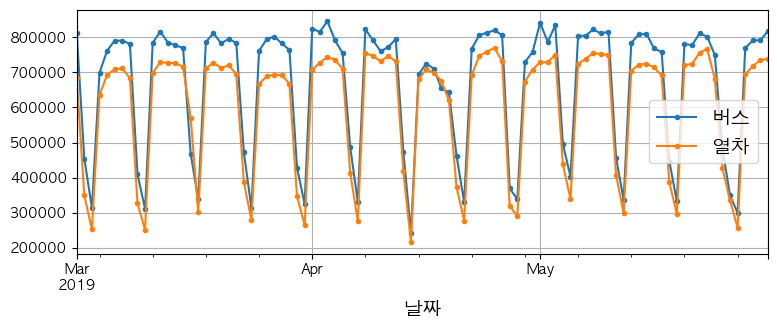

In [5]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.legend(["버스", "열차"]);
plt.xlabel("날짜")
save_fig("daily_ridership_plot")
plt.show()

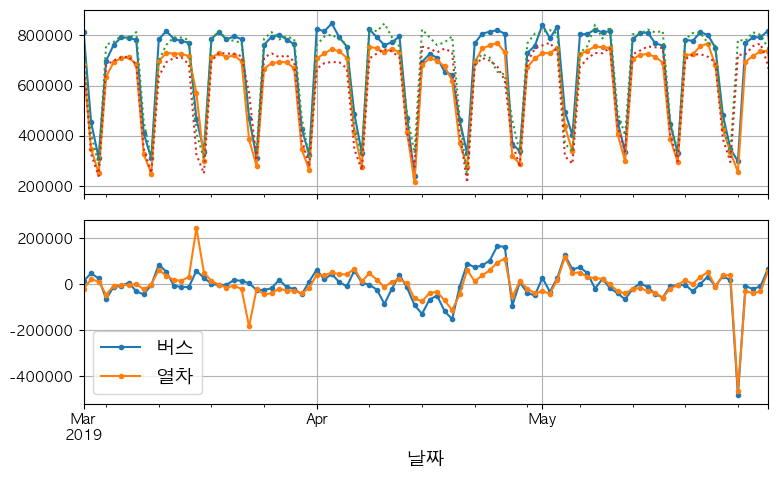

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker='.')
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[1].legend(["버스", "열차"])
axs[1].set_xlabel("날짜")
axs[0].set_ylim([170_000, 900_000])
save_fig("differencing_plot")
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [8]:
df.loc["2019-05-25":"2019-05-27"]["day_type"]

date
2019-05-25    A
2019-05-26    U
2019-05-27    U
Name: day_type, dtype: object

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

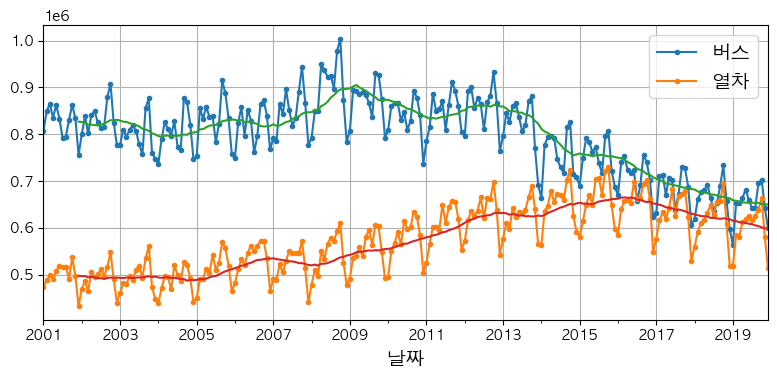

In [11]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean(numeric_only=True)
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
ax.legend(["버스", "열차"])
ax.set_xlabel("날짜")
save_fig("long_term_ridership_plot")
plt.show()

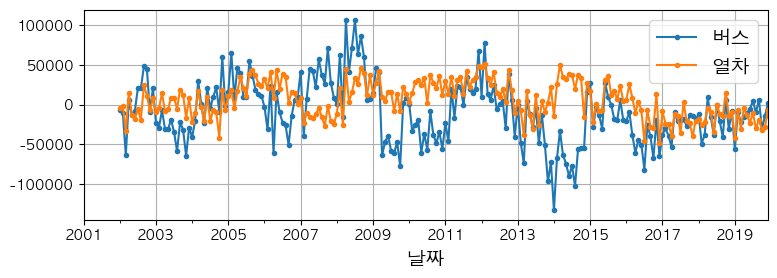

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.legend(["버스", "열차"])
plt.xlabel("날짜")
save_fig("yearly_diff_plot")
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [14]:
y_pred[0]

427758.6262864085

In [15]:
df["rail"].loc["2019-06-01"]

379044

In [16]:
df["rail"].loc["2019-05-25"]

426932

In [17]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [18]:
mae

32040.720091784442

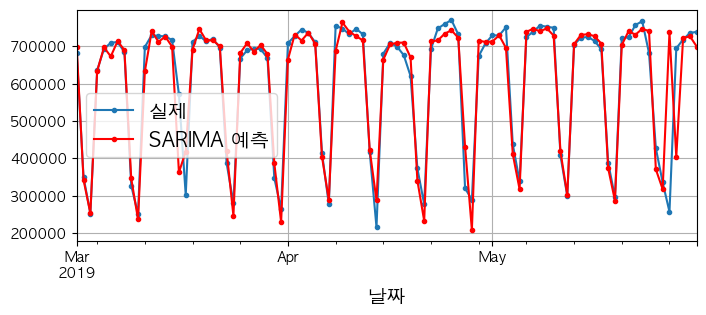

In [19]:
fix, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="실제", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA 예측")
ax.set_xlabel("날짜")
plt.legend()
plt.show()

In [26]:
df_monthly

,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065
...,...,...
2021-07-31,342101.096774,257660.193548
2021-08-31,353215.516129,260038.548387
2021-09-30,401958.833333,299608.366667


In [27]:
df.resample('M').mean(numeric_only=True)

,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065
...,...,...
2021-07-31,342101.096774,257660.193548
2021-08-31,353215.516129,260038.548387
2021-09-30,401958.833333,299608.366667


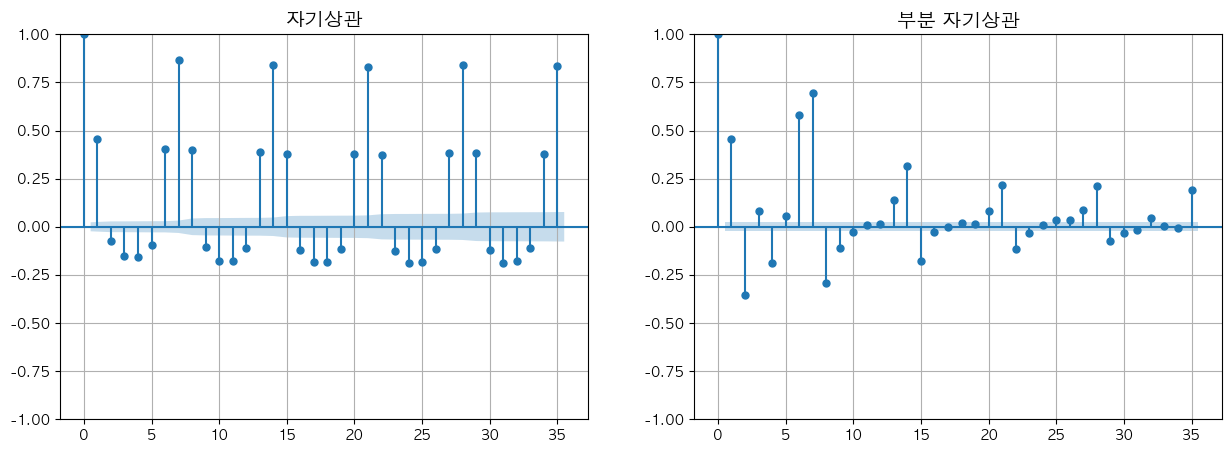

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35, title="자기상관")
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm", title="부분 자기상관")
axs[1].grid()
plt.show()

In [29]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2023-12-04 16:14:55.960994: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-04 16:14:55.961081: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-04 16:14:55.961101: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-04 16:14:55.961448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 16:14:55.961887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [30]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2023-12-04 16:16:39.393563: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [31]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_dataset in dataset:
    print(f"{window_dataset}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [32]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [33]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2016-01":"2018-12"] / 1e6
rail_test = df["rail"]["2019-06"] / 1e6

In [34]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


2023-12-04 16:25:14.705303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-04 16:25:14.720221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


33/33 [==============================] - 1s 13ms/step - loss: 0.1277 - mae: 0.3811 - val_loss: 0.0137 - val_mae: 0.1237
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0150 - mae: 0.1327 - val_loss: 0.0111 - val_mae: 0.1050
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0110 - mae: 0.1083 - val_loss: 0.0093 - val_mae: 0.0951
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0096 - mae: 0.0986 - val_loss: 0.0087 - val_mae: 0.0954
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0081 - mae: 0.0891 - val_loss: 0.0074 - val_mae: 0.0838
Epoch 6/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0075 - mae: 0.0848 - val_loss: 0.0078 - val_mae: 0.0869
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0071 - mae: 0.0830 - val_loss: 0.0069 - val_mae: 0.0803
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0064 - mae: 

In [41]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

33/33 [==============================] - 4s 101ms/step - loss: 0.0162 - mae: 0.1597


159705.63888549805

In [42]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [43]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True
    )
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [44]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 24s 717ms/step - loss: 0.4388 - mae: 0.7821 - val_loss: 0.0242 - val_mae: 0.2030
Epoch 2/500
33/33 [==============================] - 23s 691ms/step - loss: 0.0373 - mae: 0.2158 - val_loss: 0.0374 - val_mae: 0.2109
Epoch 3/500
33/33 [==============================] - 23s 684ms/step - loss: 0.0223 - mae: 0.1583 - val_loss: 0.0152 - val_mae: 0.1608
Epoch 4/500
33/33 [==============================] - 23s 694ms/step - loss: 0.0149 - mae: 0.1580 - val_loss: 0.0148 - val_mae: 0.1501
Epoch 5/500
33/33 [==============================] - 22s 682ms/step - loss: 0.0147 - mae: 0.1516 - val_loss: 0.0145 - val_mae: 0.1506
Epoch 6/500
33/33 [==============================] - 24s 733ms/step - loss: 0.0145 - mae: 0.1506 - val_loss: 0.0144 - val_mae: 0.1505
Epoch 7/500
33/33 [==============================] - 27s 815ms/step - loss: 0.0143 - mae: 0.1526 - val_loss: 0.0142 - val_mae: 0.1500
Epoch 8/500
33/33 [==============================] - 24s 720ms

KeyboardInterrupt: 

In [45]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(1),
    tf.keras.layers.Dense(1)
])

In [46]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500


2023-12-04 17:29:29.268042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_10.


33/33 [==============================] - 109s 3s/step - loss: 0.0157 - mae: 0.1453 - val_loss: 0.0124 - val_mae: 0.1305
Epoch 2/500
33/33 [==============================] - 119s 4s/step - loss: 0.0081 - mae: 0.1011 - val_loss: 0.0056 - val_mae: 0.0718
Epoch 3/500
33/33 [==============================] - 111s 3s/step - loss: 0.0053 - mae: 0.0688 - val_loss: 0.0046 - val_mae: 0.0649
Epoch 4/500
33/33 [==============================] - 121s 4s/step - loss: 0.0046 - mae: 0.0637 - val_loss: 0.0044 - val_mae: 0.0619
Epoch 5/500
33/33 [==============================] - 119s 4s/step - loss: 0.0043 - mae: 0.0608 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 6/500
33/33 [==============================] - 109s 3s/step - loss: 0.0041 - mae: 0.0578 - val_loss: 0.0041 - val_mae: 0.0573
Epoch 7/500
33/33 [==============================] - 115s 4s/step - loss: 0.0041 - mae: 0.0583 - val_loss: 0.0041 - val_mae: 0.0596
Epoch 8/500
33/33 [==============================] - 110s 3s/step - loss: 0.0040 - mae: 

KeyboardInterrupt: 

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06"]

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # 5개의 열을 모두 입력으로 사용
    targets=mulvar_train["rail"][seq_length:],  # 열차 시계열만 예측
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [ ]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

In [ ]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds, learning_rate=0.02)

In [ ]:
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

In [ ]:
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx]
    )
    print(name, int(mae))

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

In [ ]:
Y_pred = pd.Serise(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="진짜", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="예측", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="오늘")
ax.set_ylim([200_000, 800_000])
ax.set_xlabel("날짜")
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.kears.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(24)
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length),map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.kears.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])



In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for + {ahead + 1}: {mae:,.0f}")

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]
        
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0)
        )
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.kears.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)
gru_model = tf.keras.models.Sequential([
    tf.kears.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 논문에서는 10
n_blocks = 1  # 논문에서는 3
n_filters = 32  # 논문에서는 128
n_outputs = 14  # 논문에서는 256

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)